## Vehicle Detection Project

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
from skimage.feature import hog
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn import grid_search
from scipy.ndimage.measurements import label
import time

## Loading data

In [2]:
import glob

In [3]:
def load_data(path):
    directories = glob.glob(path)
    image_paths = []
    for directory in directories:
        d_paths = glob.glob(directory + '/*.png')
        image_paths += d_paths
        print('Directory %s has %d images, total images so far = %d'%(directory, len(d_paths), len(image_paths)))
    return image_paths

In [8]:
non_vehicle_paths = load_data('../data/non-vehicles/*')

Directory ../data/non-vehicles\Extras has 5068 images, total images so far = 5068
Directory ../data/non-vehicles\GTI has 3900 images, total images so far = 8968


In [9]:
vehicle_paths = load_data('../data/vehicles/*')

Directory ../data/vehicles\GTI_Far has 834 images, total images so far = 834
Directory ../data/vehicles\GTI_Left has 909 images, total images so far = 1743
Directory ../data/vehicles\GTI_MiddleClose has 419 images, total images so far = 2162
Directory ../data/vehicles\GTI_Right has 664 images, total images so far = 2826
Directory ../data/vehicles\KITTI_extracted has 5966 images, total images so far = 8792


## Examples of car and non-car images

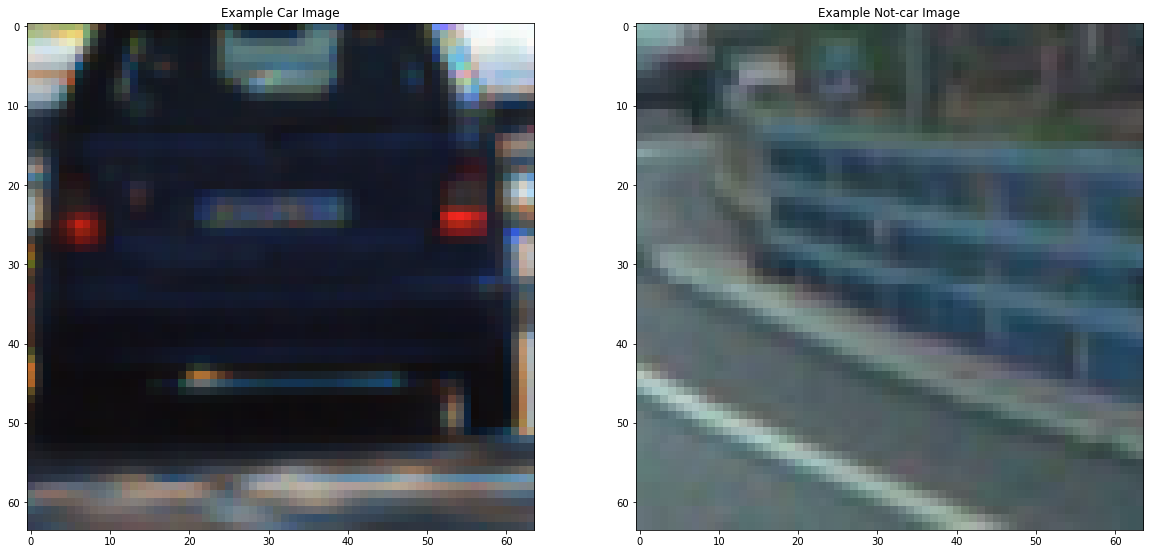

In [10]:
# Read in car / not-car images
n_car_images = len(vehicle_paths)
n_noncar_images = len(non_vehicle_paths)
car_ind = random.randint(0, n_car_images)
notcar_ind = random.randint(0, n_noncar_images)
car_image = mpimg.imread(vehicle_paths[car_ind])
notcar_image = mpimg.imread(non_vehicle_paths[notcar_ind])


# Plot the examples
fig = plt.figure(figsize=[20,20])
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## HOG features on random vehicle and non-vehicle images

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

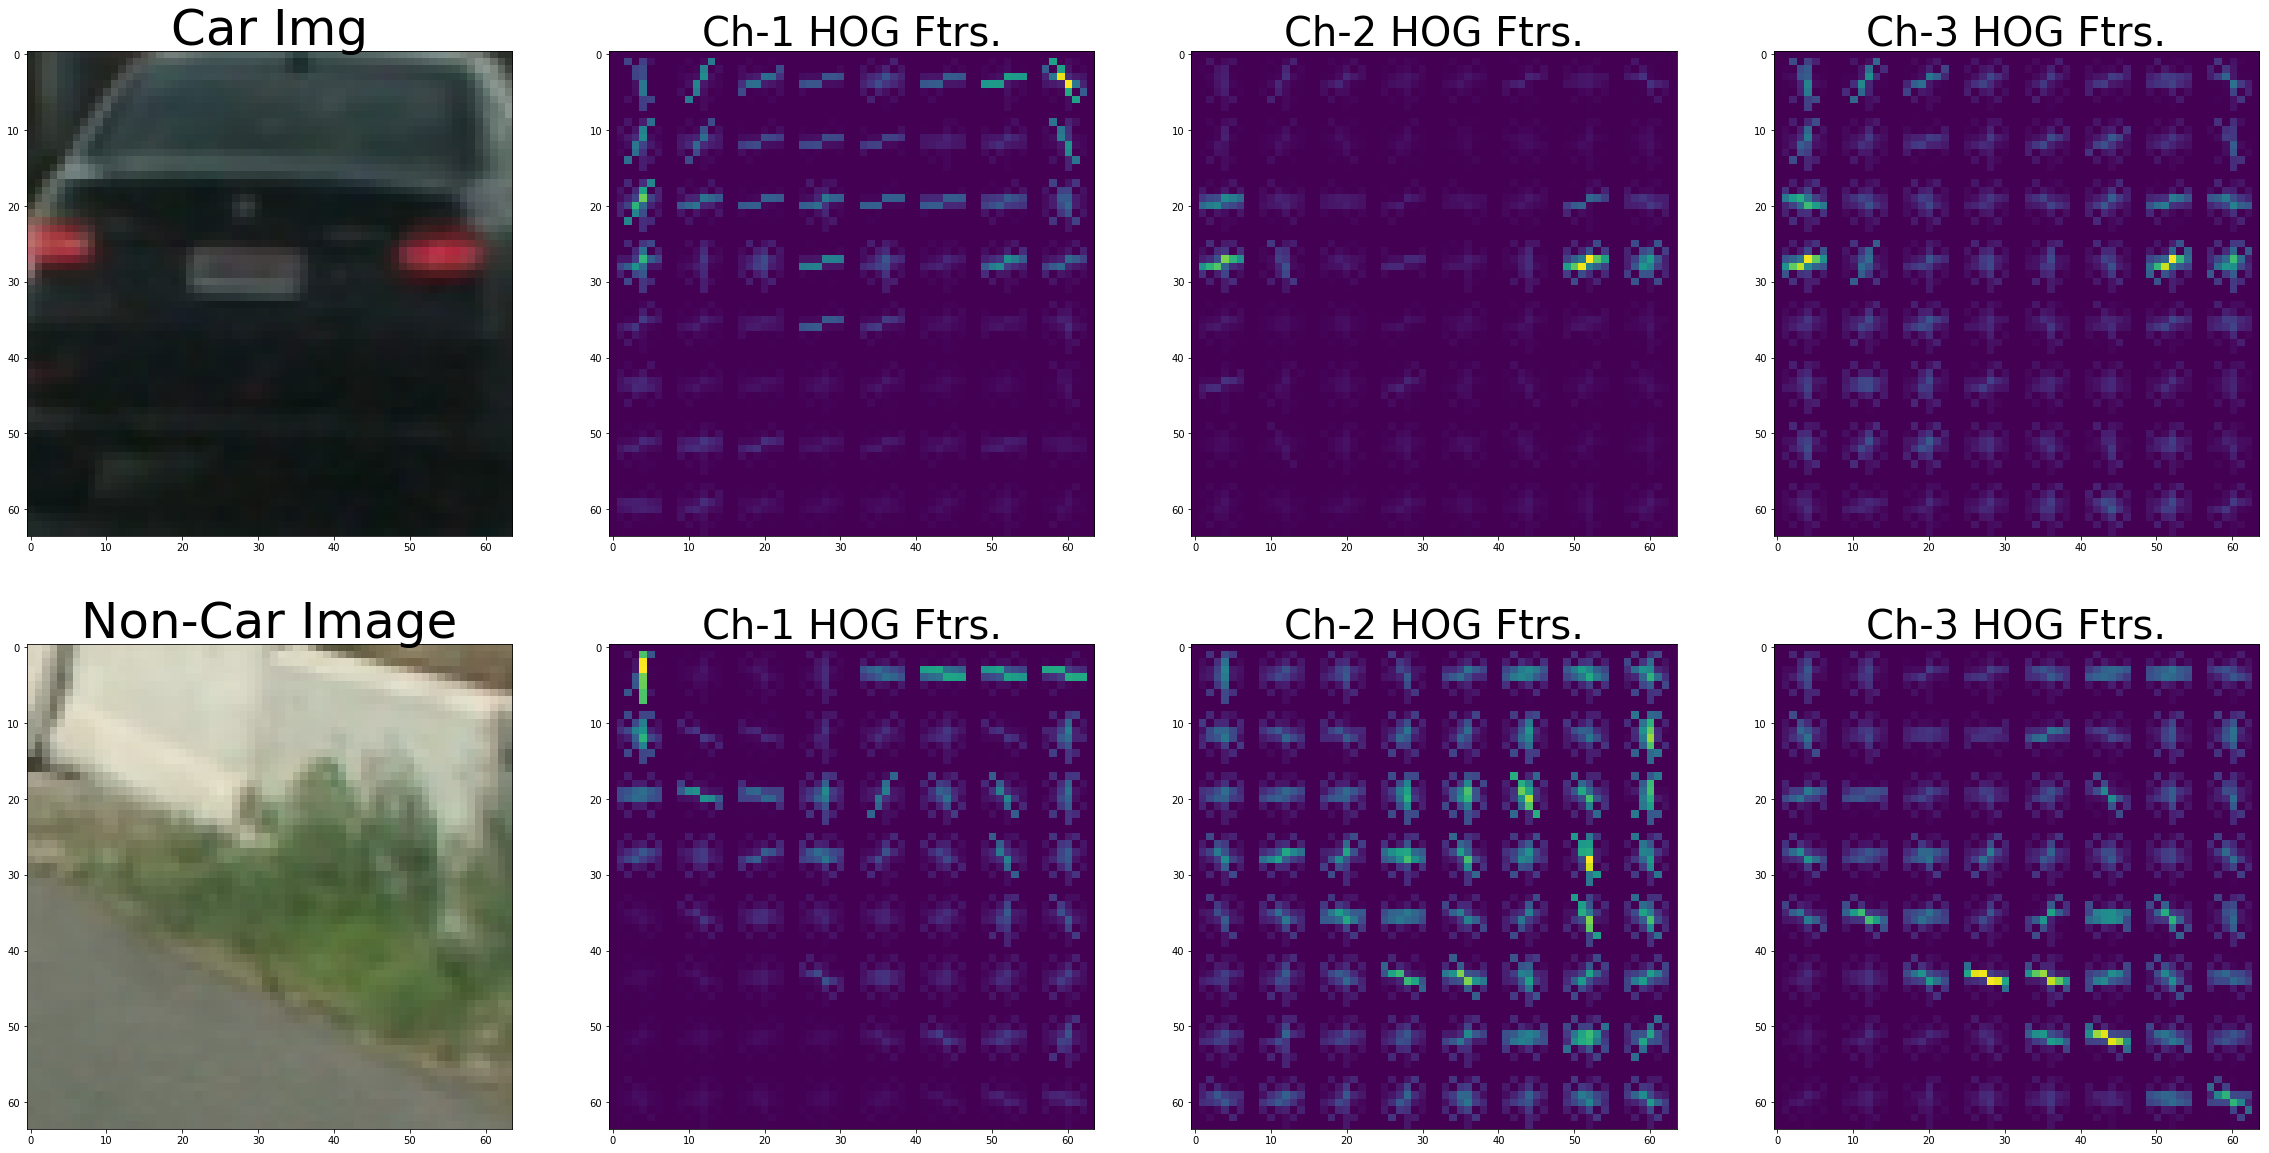

In [12]:
# Generate a random index to look at a car image
car_ind = random.randint(0, n_car_images)
noncar_ind = random.randint(0, n_noncar_images)
# Read in the image
car_image = mpimg.imread(vehicle_paths[car_ind])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)[:,:,2]

noncar_image = mpimg.imread(non_vehicle_paths[noncar_ind])
noncar_gray = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YCrCb)[:,:,2]
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output

fig, axs = plt.subplots(2,4, figsize=(40, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
cntr = 0
for source_img in [car_image, noncar_image]:
    channels = cv2.cvtColor(source_img, cv2.COLOR_RGB2YCrCb)
    axs[cntr].imshow(source_img)
    title = 'Car Img' if cntr == 0 else 'Non-Car Image'
    axs[cntr].set_title(title, size=50)
    for channel in range(3):
        channel_img = channels[:,:,channel]
        # Call our function with vis=True to see an image output
        features, hog_img = get_hog_features(channel_img, orient, 
                                pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=False)
        cntr+=1
        axs[cntr].imshow(hog_img)
        channel_title = 'Ch-' + str(channel+1) + ' HOG Ftrs.'
        axs[cntr].set_title(channel_title, size=40)
    cntr+=1

In [13]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 1.0)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [14]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            elif hog_channel == 'GRAY':
                gray_image = cv2.cvtColor(feature_image.copy(), cv2.COLOR_RGB2GRAY)
                hog_features = get_hog_features(gray_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [15]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, "ALL", "GRAY"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
scale_x = True

In [16]:
car_features = extract_features(vehicle_paths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicle_paths, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
scaled_X = X
# Fit a per-column scaler
X_scaler = None
if scale_x:
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Shuffle data, may not be necessary when followed by train_test_split()
random_indices = np.random.choice(y.shape[0], y.shape[0], replace=False)
scaled_X = scaled_X[random_indices,]
y = y[random_indices]

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
#svc = svm.SVC(kernel='rbf', C=10)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
3.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9921


In [17]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            elif hog_channel == 'GRAY':
                gray_image = cv2.cvtColor(feature_image.copy(), cv2.COLOR_RGB2GRAY)
                hog_features = get_hog_features(gray_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        elif hog_channel == 'GRAY':
            gray_image = cv2.cvtColor(feature_image.copy(), cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(gray_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = np.array(features).reshape(1, -1)
        #5) Scale extracted features to be fed to classifier
        if scaler is not None:
            test_features = scaler.transform(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

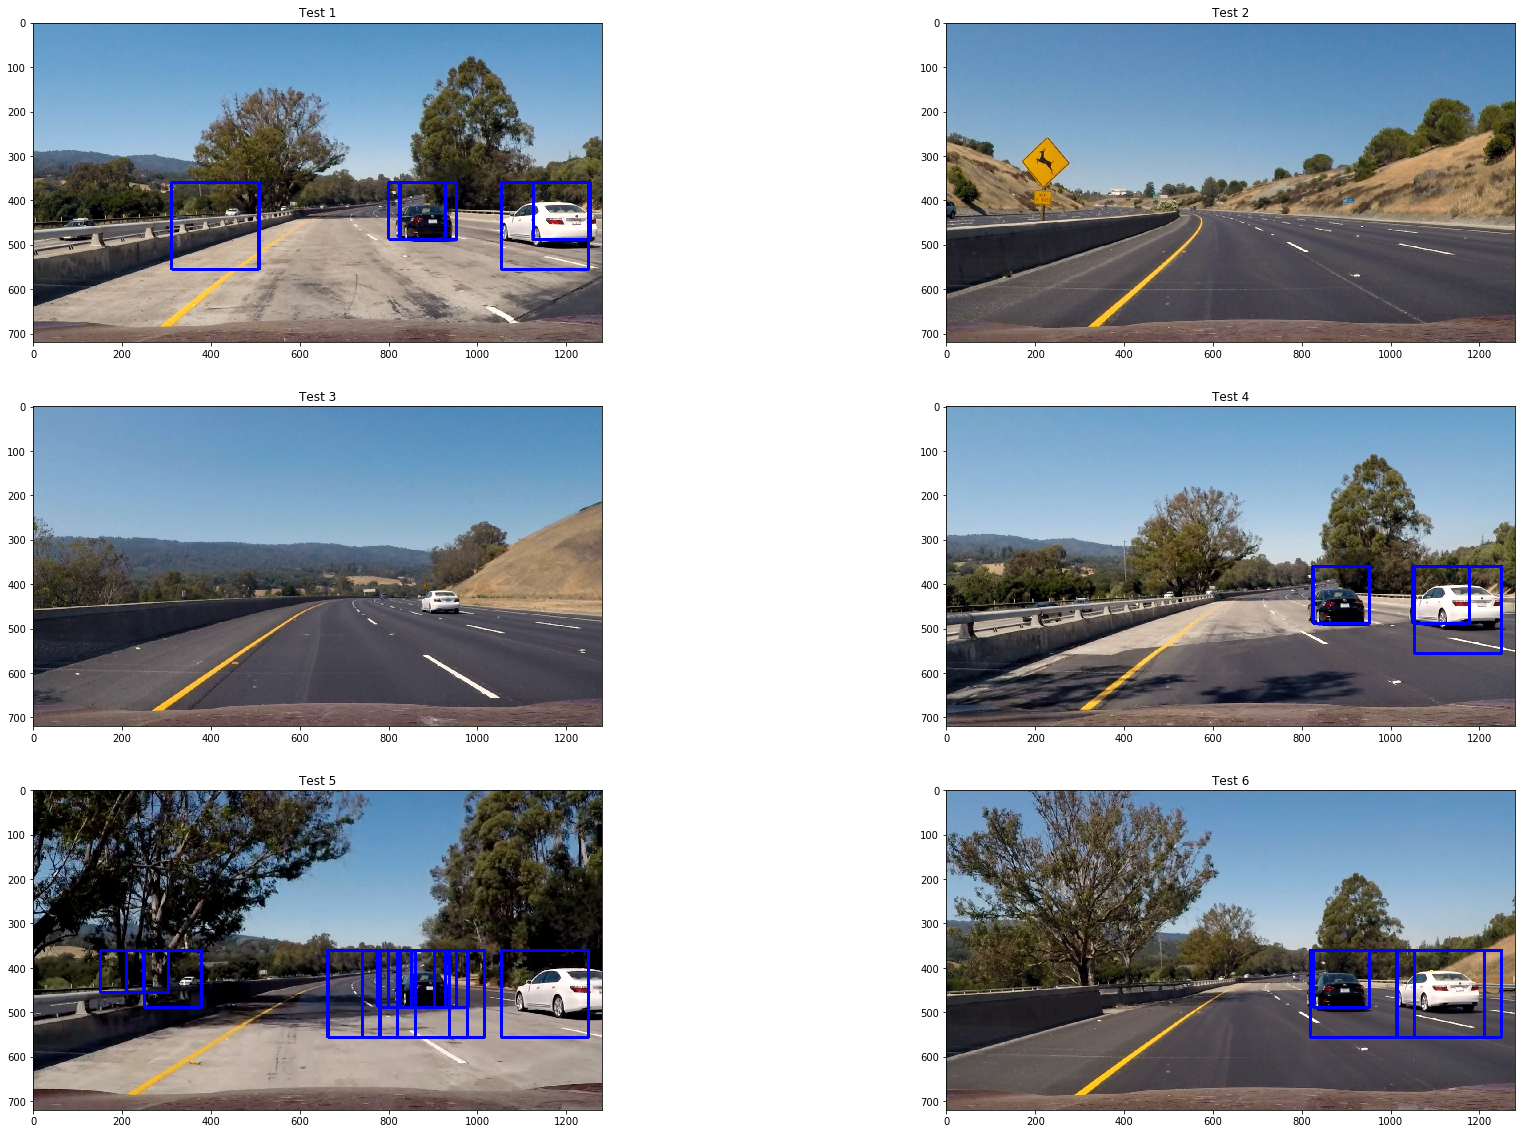

In [18]:
t=time.time()
path = './test_images/test%d.jpg'
final_images = []
fig, axs = plt.subplots(3,2, figsize=(30, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
for img_idx in range(1, 7):
    image = mpimg.imread(path%(img_idx))
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    y_start_stop = [image.shape[0]//2, image.shape[0]] # Min and max in y to search in slide_window()
    scales = [64, 96, 128, 196]
    windows = []
    for scale in scales:
        y_start_stop = [image.shape[0]//2, scale + image.shape[0]//2] # Min and max in y to search in slide_window()
        windows_ = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(scale, scale), xy_overlap=(0.8, 0.8))
        windows.extend(windows_)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    final_images.append(window_img)
    axs[img_idx-1].imshow(window_img)
    axs[img_idx-1].set_title('Test %d'%(img_idx))

## Multiple Detections

In [19]:
def convert_color(image, color_space='YCrCb'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)  
    return feature_image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 1.0)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
#def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
#              pix_per_cell, cell_per_block, color_space, 
#              spatial_size, hist_bins):
    
def find_cars(img, ystart, ystop, scale, svc, 
              X_scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = img_tosearch
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_feat == True:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            img_features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Get color features
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                #4) Append features to list
                img_features.append(spatial_features)
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
                #6) Append features to list
                img_features.append(hist_features)
            # Extract HOG for this patch
            if hog_feat == True:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                img_features.append(hog_features)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = np.concatenate(img_features).reshape(1,-1)
            if X_scaler is not None:
                test_features = X_scaler.transform(test_features) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),
                       (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_list.append(box)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return [box_list, draw_img]

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

1 15
2 0
3 1
4 14
5 12
6 16


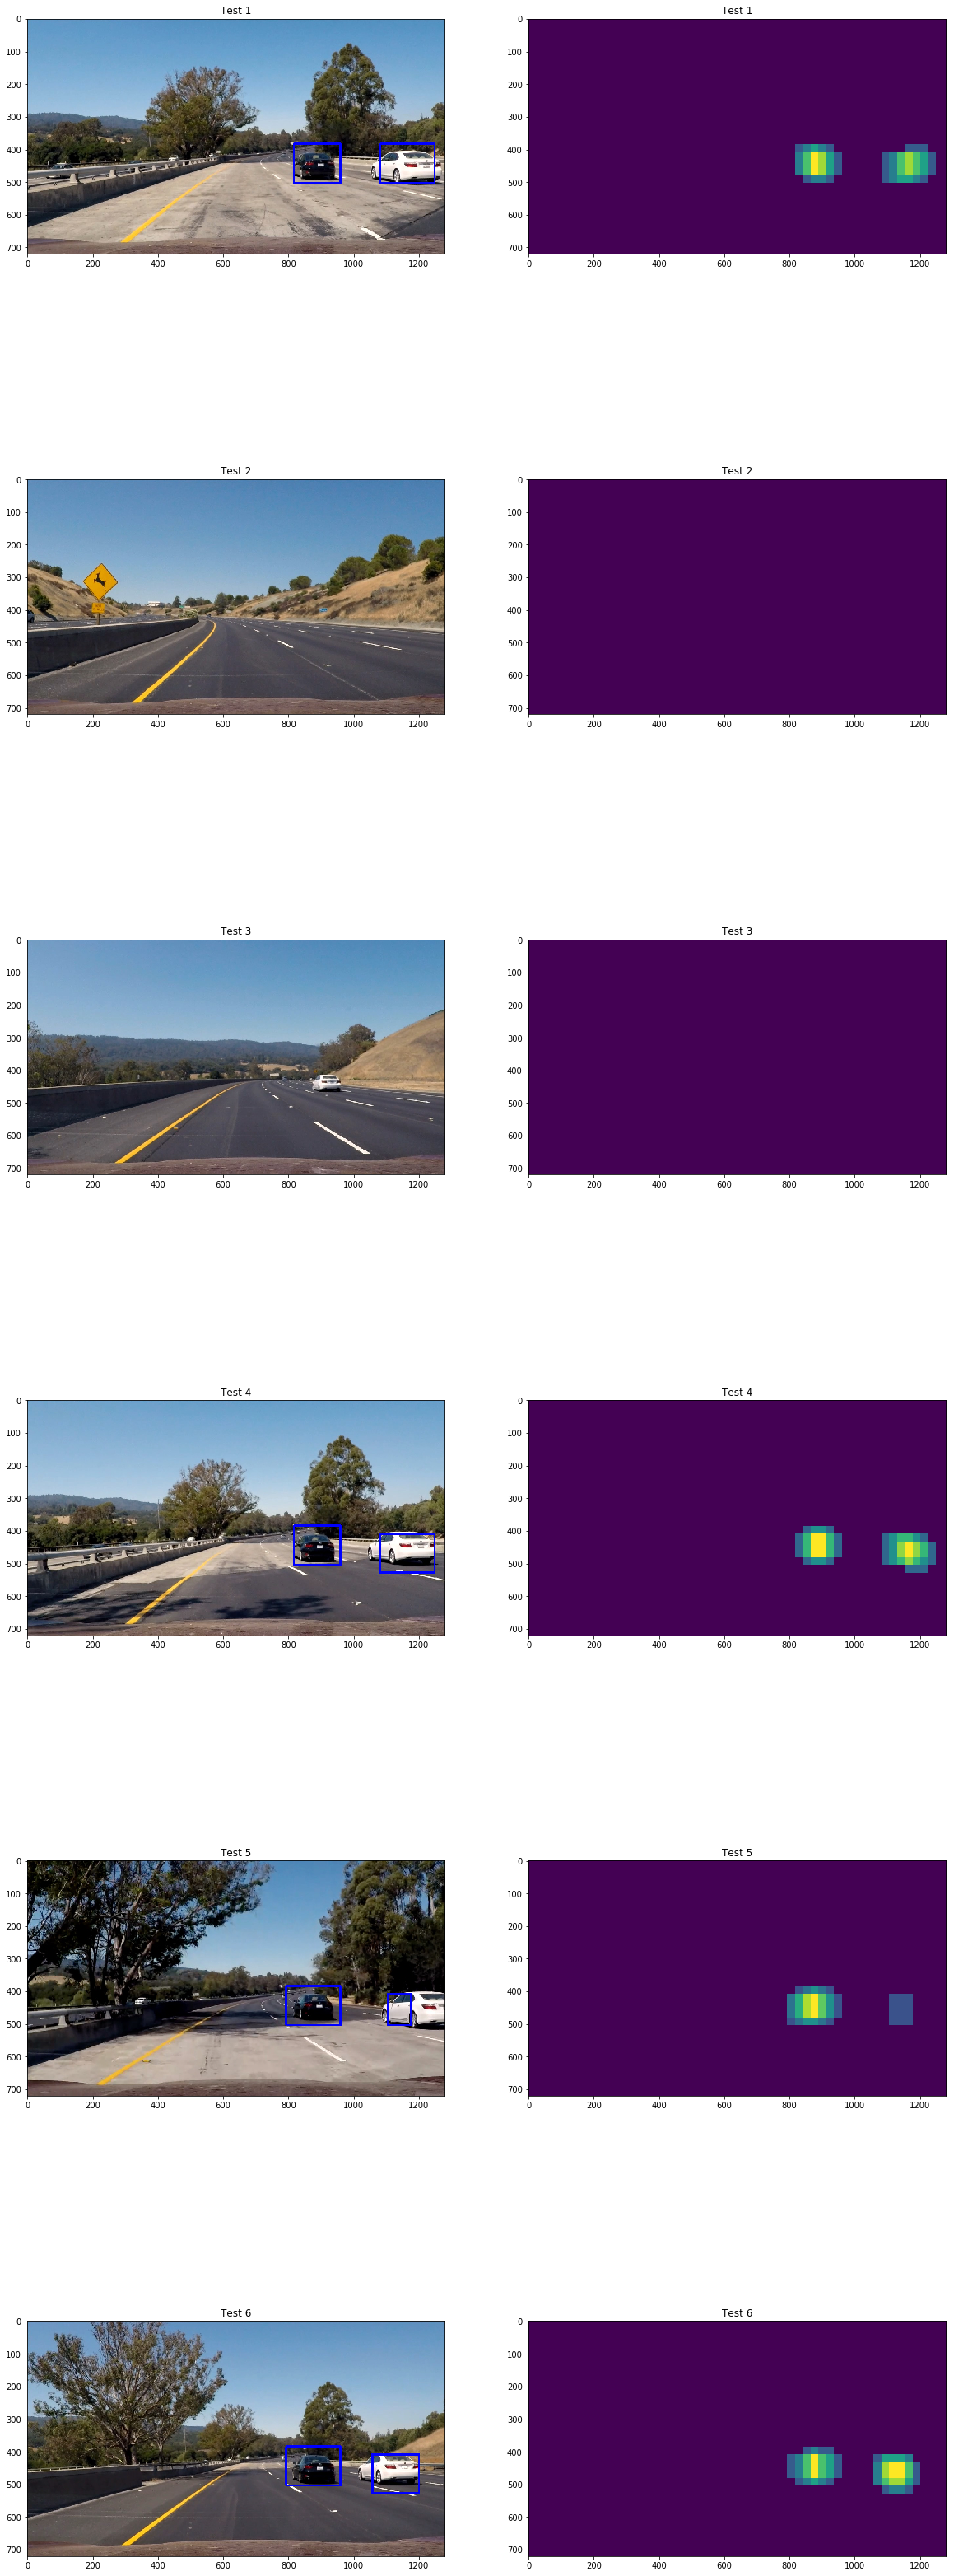

In [20]:
t=time.time()
path = 'C:\\Users\\hashtawy\\Documents\\courses\\udacity\\ave\\CarND-Vehicle-Detection\\test_images\\test%d.jpg'
path = './test_images/test%d.jpg'
final_images = []
fig, axs = plt.subplots(6,2, figsize=(20, 60), facecolor='w', edgecolor='k')
axs = axs.ravel()
cntr = 0
for img_idx in range(1, 7):
    image = mpimg.imread(path%(img_idx))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_image = np.copy(image)

    img = draw_image.astype(np.float32)
    #box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
    #                     pix_per_cell, cell_per_block, color_space, 
     #                    spatial_size, hist_bins)
    hist_range = (0, 1.0)
    str_stp_scl_s = [(360, 650, 1.5),
                     #(360, 424, 1.0),
                     #(360, 700, 2.0),
                    (416, 480, 1.0),
                     (460, 588, 2.0),
                   (400, 496, 1.5),
                   (400, 464, 1.0),
                   (432, 528, 1.5), 
                   (400, 528, 2.0), 
                   (432, 560, 2.0), 
                   (400, 596, 3.5), 
                   (464, 660, 3.5)]
    box_list=[]
    for str_stp_scl in str_stp_scl_s:
        ystart, ystop, scale = str_stp_scl
        rr, _ = find_cars(img.copy(), ystart, ystop, scale, svc, 
                             X_scaler, color_space, 
                            spatial_size, hist_bins, 
                            hist_range, orient, 
                            pix_per_cell, cell_per_block, 
                            hog_channel, spatial_feat, 
                            hist_feat, hog_feat)
        for rrr in rr:
            box_list.append(rrr)
        #box_list.extend(rr)
    print(img_idx, len(box_list))
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    axs[cntr].imshow(draw_img)
    axs[cntr].set_title('Test %d'%(img_idx))
    cntr+=1
    axs[cntr].imshow(heatmap)
    axs[cntr].set_title('Test %d'%(img_idx))
    cntr+=1

## Video Pipeline

In [21]:
class Detection_Memory():
    def __init__(self):
        self.thrsh = 2
        self.prev_detections = []
    def push_detections(self, detections):
        for detection in detections:
            self.prev_detections.append(detection)
        print(len(self.prev_detections))
        if len(self.prev_detections) > self.thrsh:
            self.prev_detections = self.prev_detections[len(self.prev_detections)-self.thrsh:]

In [22]:
def process_frame_for_video(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = image.astype(np.float32)
    rectangles = []

    hist_range = (0, 1.0)
    str_stp_scl_s = [(400, 464, 1.0),
                    (416, 480, 1.0),
                     (460, 588, 2.0),
                     (400, 665, 1.5),
                   (400, 496, 1.5),
                   (432, 528, 1.5), 
                   (400, 528, 2.0), 
                   (432, 560, 2.0), 
                   (400, 596, 3.5),
                     (360, 650, 1.5),
                   (464, 660, 3.5)]
    #rr = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
    #                            pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for str_stp_scl in str_stp_scl_s:
        ystart, ystop, scale = str_stp_scl
        rr, _ =l find_cars(img.copy(), ystart, ystop, scale, svc, 
                             X_scaler, color_space, 
                            spatial_size, hist_bins, 
                            hist_range, orient, 
                            pix_per_cell, cell_per_block, 
                            hog_channel, spatial_feat, 
                            hist_feat, hog_feat)
        if len(rr) > 0:
            rectangles.extend(rr)
    # add detections to the history
    if len(rectangles) > 0:
        det.push_detections(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    #print('hi')
    for rect_set in det.prev_detections:
        #print(rect_set)
        heatmap_img = add_heat(heatmap_img, [rect_set])
    #print('bye')
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_detections)//2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [25]:
fnames = ['project_video'] #,'project_video.mp4']#, 'solidYellowLeft.mp4']
for fname in fnames:
    det = Detection_Memory()
    #det = Vehicle_Detect()
    in_vid_fname = "./images_and_videos/" + fname + '.mp4'
    out_vid_fname = './images_and_videos/' + fname + '_detected.mp4'
    clip1 = VideoFileClip(in_vid_fname)
    white_clip = clip1.fl_image(process_frame_for_video) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(out_vid_fname, audio=False)

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_vid_fname))